In [ ]:
import warnings
warnings.filterwarnings('ignore')
default_plot_colour = "#00bfbf"

In [ ]:
pip install vaderSentiment

**Importing Necessary Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize ,sent_tokenize
nltk.download('wordnet')
from nltk.stem import PorterStemmer , WordNetLemmatizer
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy ,tokenizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import gensim
from gensim import corpora
from gensim.models import LdaModel ,LsiModel
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report ,confusion_matrix
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data Exploration : POS - NER**

In [ ]:
from google.colab import files
data_file = files.upload()

Saving fake_news_data.csv to fake_news_data (3).csv


In [ ]:
data = pd.read_csv('fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


1- **POS**

In [ ]:
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

In [ ]:
fake_spacy_docs = list(nlp.pipe(fake_news['text']))
fact_spacy_docs = list(nlp.pipe(fact_news['text']))

In [ ]:
def extract_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [ ]:
fake_tags_df = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spacy_docs):
    tags = extract_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tags_df.append(tags)

fake_tags_df = pd.concat(fake_tags_df)

# tag factual dataset
fact_tags_df = []

for ix, doc in enumerate(fact_spacy_docs):
    tags = extract_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tags_df.append(tags)

fact_tags_df = pd.concat(fact_tags_df)
fake_tags_df.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [ ]:
# token frequency count (fake)
pos_counts_fake = fake_tags_df.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)
# token frequency count (fact)
pos_counts_fact = fact_tags_df.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [ ]:
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2597
VERB,1814
PROPN,1657
ADJ,876
ADV,412
NUM,221
PRON,99
ADP,88
AUX,58


In [ ]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2182
VERB,1535
PROPN,1387
ADJ,753
ADV,271
NUM,203
PRON,81
ADP,70
AUX,44


In [ ]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [ ]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


**2- NER**

In [ ]:
# top entities in fake news
top_entities_fake = fake_tags_df[fake_tags_df['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)
# top entities in fact news
top_entities_fact = fact_tags_df[fact_tags_df['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

In [ ]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

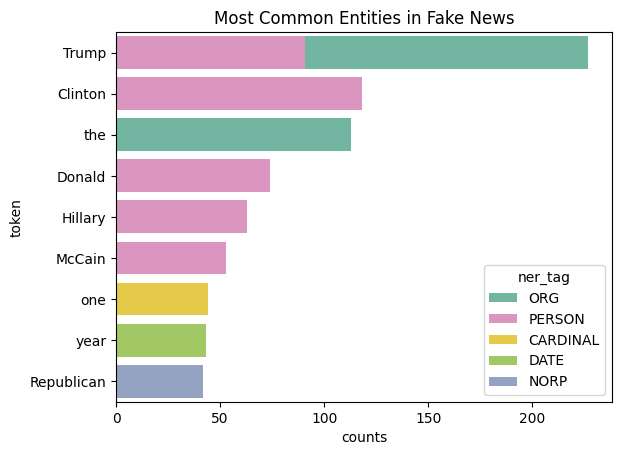

In [ ]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

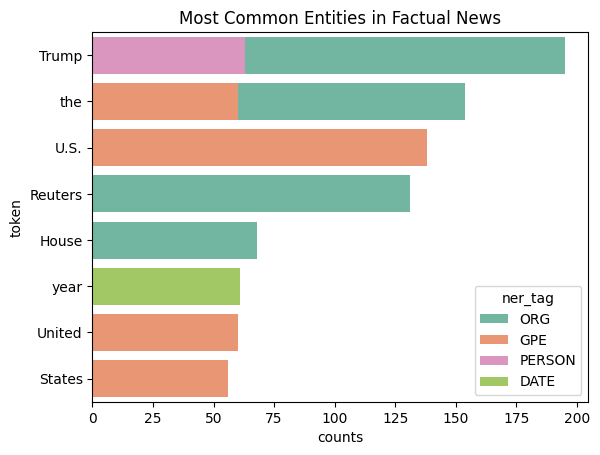

In [ ]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

**Text Preprocessing**

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [ ]:
data['text_clean'] = data['text'].apply(lambda x: re.sub(r"^[^-]*-\s*" , "" , x))

In [ ]:
data['text_clean'] = data['text_clean'].str.lower()

In [ ]:
data['text_clean']  = data['text_clean'].apply(lambda x: re.sub(r'[^\w\s]' ,'',x ))

In [ ]:
en_stopwords = stopwords.words('english')
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in( en_stopwords)]))

In [ ]:
data['text_clean']  = data['text_clean'].apply(lambda x: word_tokenize(x))

In [ ]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [ ]:
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
print(unigrams[:10])

(said,)          560
(trump,)         520
(u,)             255
(state,)         250
(president,)     226
(would,)         210
(one,)           141
(year,)          128
(republican,)    128
(also,)          124
Name: count, dtype: int64


In [ ]:
print(unigrams.index)
unigrams.index = unigrams.index.map(lambda x: x[0])

Index([      ('said',),      ('trump',),          ('u',),      ('state',),
        ('president',),      ('would',),        ('one',),       ('year',),
       ('republican',),       ('also',),
       ...
        ('fourmonth',),      ('tutor',),   ('lakeland',),      ('pared',),
        ('undecided',),   ('stronger',),     ('streak',),  ('bennewise',),
            ('patsy',),  ('petrosyan',)],
      dtype='object', length=8571)


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

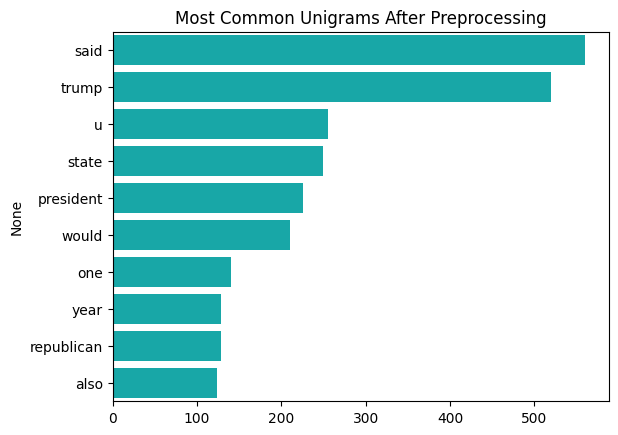

In [ ]:
sns.barplot(x = unigrams.values[:10],
            y = unigrams.index[:10],
            orient = 'h',
            palette=[default_plot_colour])\
.set(title='Most Common Unigrams After Preprocessing')

**Sentiment Analysis**

In [ ]:
vader_sentiment = SentimentIntensityAnalyzer()
data['vader_sentiment'] = data['text'].apply(lambda x:vader_sentiment.polarity_scores(x)['compound'])
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [ ]:
bins = [-1,-.1,.1,1]
names=['negative', 'natural' ,'positive']
data['sentiment_labels'] = pd.cut(data['vader_sentiment'] , bins , labels=names)
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment,sentiment_labels
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


[Text(0.5, 1.0, 'Fake and Factual News by Sentiment Analysis')]

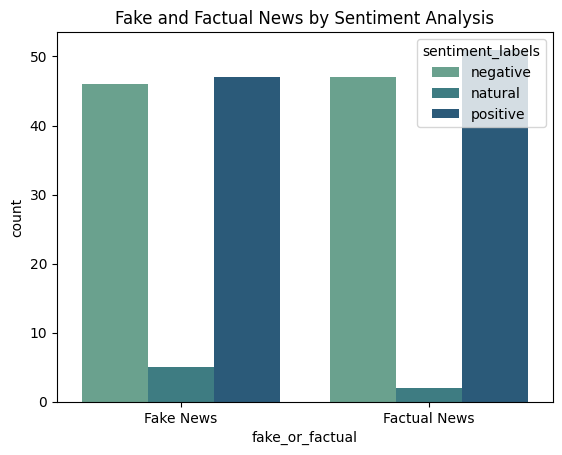

In [ ]:
sns.countplot(
    x= data['fake_or_factual'],
    hue = data['sentiment_labels'],
    data = data ,
    palette= "crest"
).set(title = 'Fake and Factual News by Sentiment Analysis')

**Topic Modeling Exploration :**

**1-Latent Dirichlet Allocation (LDA) with Bag of Words (BoW):**

In [ ]:
fake_text_news = data[data['fake_or_factual']=='Fake News']['text_clean'].reset_index(drop=True) #to make new indecies for the new Series usually done after filterin or manipulation
fake_text_news.head()

,text_clean
0,"[yearold, oscarwinning, actress, described, me..."
1,"[buried, trump, bonkers, interview, new, york,..."
2,"[woman, make, 50, percent, country, grossly, u..."
3,"[58, resolution, consider, move, week, fox, ne..."
4,"[inneck, race, must, pretty, antsy, though, un..."


In [ ]:
dictionary_fake = corpora.Dictionary(fake_text_news)

In [ ]:
doc_term_fake = [dictionary_fake.doc2bow(i) for i in fake_text_news]

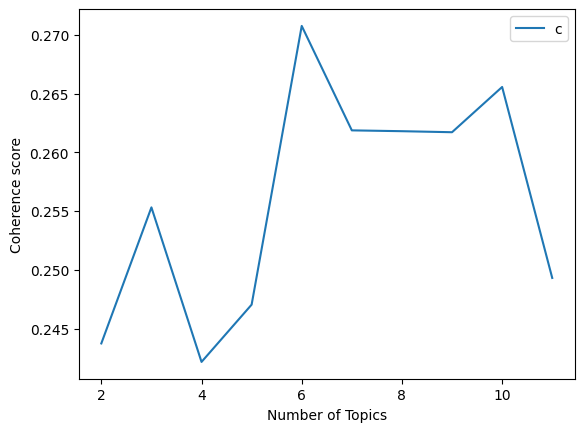

In [ ]:
model_list = []
coherence_values = []
min_topics = 2
max_topics = 11

for num_topis_i in range(min_topics ,max_topics+1):
  model = LdaModel(doc_term_fake , id2word=dictionary_fake , num_topics=num_topis_i)
  model_list.append(model)
  coherence_model = CoherenceModel(model=model , texts=fake_text_news ,dictionary=dictionary_fake , coherence='c_v')
  coherence_values.append(coherence_model.get_coherence())

plt.plot(range(min_topics ,max_topics+1) , coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
final_num_topics = 7
final_model = LdaModel(corpus=doc_term_fake , id2word=dictionary_fake , num_topics=final_num_topics )
final_model.print_topics(num_topics=final_num_topics , num_words=10)

[(0,
  '0.006*"trump" + 0.005*"president" + 0.004*"would" + 0.004*"u" + 0.004*"republican" + 0.003*"state" + 0.003*"say" + 0.003*"one" + 0.003*"year" + 0.003*"know"'),
 (1,
  '0.009*"trump" + 0.005*"would" + 0.004*"said" + 0.004*"student" + 0.004*"president" + 0.004*"time" + 0.003*"u" + 0.003*"people" + 0.003*"state" + 0.003*"republican"'),
 (2,
  '0.011*"trump" + 0.006*"said" + 0.005*"president" + 0.004*"clinton" + 0.004*"state" + 0.003*"image" + 0.003*"u" + 0.003*"time" + 0.003*"right" + 0.002*"would"'),
 (3,
  '0.013*"trump" + 0.004*"said" + 0.004*"republican" + 0.003*"people" + 0.003*"state" + 0.003*"one" + 0.003*"school" + 0.003*"clinton" + 0.003*"like" + 0.003*"time"'),
 (4,
  '0.010*"trump" + 0.005*"clinton" + 0.004*"one" + 0.004*"state" + 0.004*"woman" + 0.003*"u" + 0.003*"said" + 0.003*"also" + 0.003*"would" + 0.003*"people"'),
 (5,
  '0.019*"trump" + 0.006*"said" + 0.005*"would" + 0.005*"clinton" + 0.004*"president" + 0.004*"time" + 0.004*"woman" + 0.003*"year" + 0.003*"also"

**2-Latent Semantic Analysis (LSA) with TF-IDF**

In [ ]:
def extract_tfidf_corpus(doc_term_matrix):
  tfidf_model = TfidfModel(corpus=doc_term_matrix , normalize=True)
  tfidf_corpus = tfidf_model[doc_term_matrix]
  return tfidf_corpus

In [ ]:
def show_coherence_scores(corpus,dictionary,text , min_topics , max_topics):
  model_list = []
  coherence_values = []

  for num_topis_i in range(min_topics , max_topics+1):
    model = LsiModel(corpus=corpus , id2word=dictionary , num_topics=num_topis_i)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model , texts=text ,dictionary=dictionary , coherence='c_v' )
    coherence_values.append(coherence_model.get_coherence())

  plt.plot(range(min_topics , max_topics+1) , coherence_values)
  plt.title('No-Topics by Coherence Score')
  plt.xlabel('Number of Topics')
  plt.ylabel('Coherence Score')
  plt.show()

In [ ]:
Tfidf_corpus_fake = extract_tfidf_corpus(doc_term_fake)

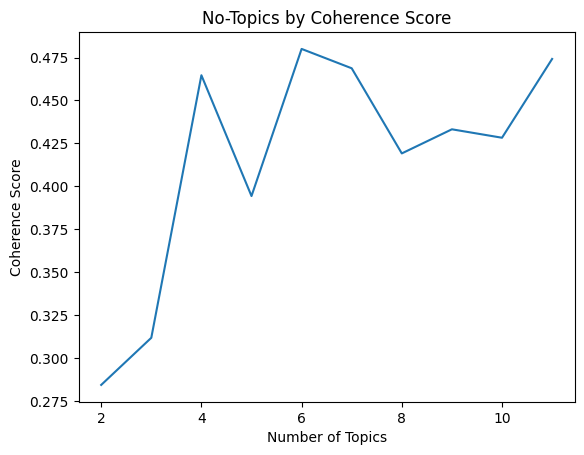

In [ ]:
show_coherence_scores(Tfidf_corpus_fake ,dictionary_fake ,fake_text_news ,min_topics=2 ,max_topics=11 )

In [ ]:
lsa_model = LsiModel(Tfidf_corpus_fake , id2word=dictionary_fake , num_topics=7)
lsa_model.print_topics(num_topics=7 ,num_words=9 )

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"hesher"'),
 (2,
  '-0.218*"school" + 0.194*"clinton" + 0.165*"conference" + -0.151*"county" + -0.136*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love"'),
 (3,
  '0.373*"flynn" + 0.151*"russian" + 0.112*"email" + 0.108*"30" + 0.101*"department" + 0.101*"information" + 0.100*"nana" + 0.099*"official" + -0.098*"trump"'),
 (4,
  '-0.235*"trump" + -0.225*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.152*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich"'),
 (5,
  '-0.247*"student" + -0.188*"school" + -0.149*"conference" + 0.128*"penny" + -0.117*"trump" + -0.107*"campus" + 0.102*"bill" + 0.094*"obama" + -0.094*"supporter"'),
 (6,
  '-0.28

**Hyper Parameter Tuning & Model Selection**

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [ ]:
X = [','.join(map(str,i))for i in data['text_clean']]
Y = data['fake_or_factual']

In [ ]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray() , columns= countvec.get_feature_names_out())

In [ ]:
x_train , x_test , y_train , y_test  = train_test_split(bag_of_words , Y ,test_size=0.3 ,random_state=42 )

In [ ]:
model_params ={
    'Logestic Regression':{
        'model':LogisticRegression(),
        'params':{
            'penalty':['l2','l1'],
            'C':[.1,1,10,20]
    }},
    'Random_Forest':{
        'model':RandomForestClassifier(),
        'params':{
                'n_estimators': [10,15,20,50,100],
                  'criterion' : ["gini", "entropy", "log_loss"]
                }},
    'SVM':{
          'model':SGDClassifier(),
          'params':{
          'alpha':[0.001,.002,.005,.1,1],
          'learning_rate' : ['optimal', 'constant', 'adaptive']
            }}
}

In [ ]:
scores_list=[]
for m_name ,m_param in model_params.items():
     model = GridSearchCV(m_param['model'],m_param['params'],cv=5,return_train_score=False)
     model.fit(x_train,y_train)
     scores_list.append({
         'model_name':m_name,
         'best_score':model.best_score_,
         'best_params':model.best_params_
     })
scores =pd.DataFrame(scores_list)
scores

,model_name,best_score,best_params
0,Logestic Regression,0.912963,"{'C': 1, 'penalty': 'l2'}"
1,Random_Forest,0.862698,"{'criterion': 'entropy', 'n_estimators': 100}"
2,SVM,0.898148,"{'alpha': 0.002, 'learning_rate': 'optimal'}"


In [ ]:
lr_model = LogisticRegression(C=1 ,penalty='l2').fit(x_train,y_train)

In [ ]:
y_pred_lr = lr_model.predict(x_test)
print(classification_report(y_test , y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.88      0.91      0.89        32
   Fake News       0.89      0.86      0.87        28

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



<Axes: >

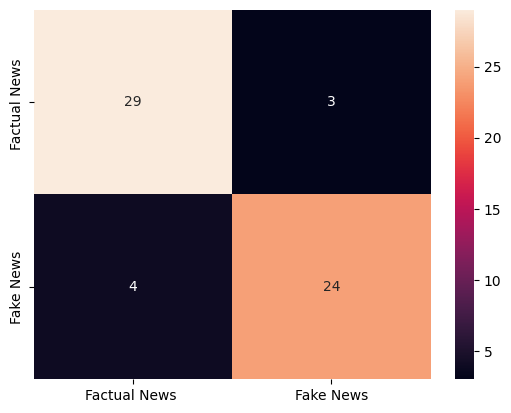

In [ ]:
labels = ['Factual News ','Fake News'  ]
cm = confusion_matrix(y_test , y_pred_lr)
sns.heatmap(cm  , annot=True ,xticklabels=labels , yticklabels=labels)